In [2]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import os
import seaborn as sns


In [5]:
def load_and_combine(mat_files):
    X_combined, Y_combined = [], []
    for file in mat_files:
        data = loadmat(file)
        X = data['X_4d']  # 确保变量名与.mat文件中的一致
        Y = data['Y_2d']  # 如果维度是(4, n_samples)，需转置为X.T
        X_combined.append(X)
        Y_combined.append(Y)
    return np.vstack(X_combined), np.vstack(Y_combined)

folder = "data_New"
with os.scandir(folder) as entries:
    mat_files = [entry.path for entry in entries if entry.name.endswith('.mat') and entry.is_file()]
X, Y = load_and_combine(mat_files)

x_scalers = [MinMaxScaler() for _ in range(4)] # 对四个维度分别 MinMaxScaler
y_scalers = [MinMaxScaler() for _ in range(2)] # 对两个维度分别 MinMaxScaler
X_scaled = np.zeros(X.shape)
Y_scaled = np.zeros(Y.shape)

for i in range(4):
    X_scaled[:, i] = x_scalers[i].fit_transform(X[:, i].reshape(-1, 1)).flatten()
for i in range(2):
    Y_scaled[:, i] = y_scalers[i].fit_transform(Y[:, i].reshape(-1, 1)).flatten()


In [3]:
for scaler in y_scalers:
    print("max:{}, min:{}".format(scaler.data_max_,scaler.data_min_))

max:[49.89999967], min:[20.69417536]
max:[-0.01730248], min:[-0.51546563]


可视化

In [4]:
import pandas as pd
data = pd.DataFrame(np.hstack([X_scaled, Y_scaled]), columns=['kappa', 'alpha','Hz','DeltE', 'T', 'OMG'])
g = sns.pairplot(
    data,
    diag_kind="kde",
    kind="scatter",
    x_vars=['kappa', 'alpha','Hz','DeltE'],
    y_vars=['T', 'OMG'],
    plot_kws=dict(s=50,edgecolor="w",color="b",alpha=.5)
    
    )
# 设置坐标轴标签
x_labels = [r'$\kappa$', r'$\alpha$', r'$H_z$', r'$\Delta E$']
y_labels = [r'$\Delta T$', r'$\Delta \Omega$']

for i, ax_row in enumerate(g.axes):  # 遍历每一行（对应 y_vars）
    for j, ax in enumerate(ax_row):  # 遍历每一列（对应 x_vars）
        # 添加外框线（默认 seaborn 会隐藏部分边框，需手动恢复）
        for spine in ['top', 'bottom', 'left', 'right']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_color('black')  # 边框颜色设为黑色
            ax.spines[spine].set_linewidth(0.5)   # 边框线宽
        
        # 设置坐标轴标签
        ax.set_xlabel(x_labels[j], fontsize=12)
        ax.set_ylabel(y_labels[i], fontsize=12)

plt.tight_layout()  # 调整布局避免标签重叠
plt.savefig("img/FourParamDistribution.png", dpi=300, format="png", bbox_inches="tight")  # 保存为 PNG
plt.show()

KeyboardInterrupt: 

: 

: 

模型训练

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from model.vae import CVAE
from model.vae_v2 import CVAE_v2
from model.simple import simple_mle
from src.utils import loss_fn, diversity_cvae_loss, generate_k_samples
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

In [6]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)
# 创建PyTorch数据集
dataset = TensorDataset(X_tensor, Y_tensor)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# 使用random_split划分数据集
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # 设置随机种子保证可重复性
)

# 创建三个数据加载器
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)


In [7]:
device = "cuda"  # cuda-使用GPU训练

model = CVAE_v2().to(device)  # 定义模型，model文件夹中
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 用优化器优化模型，lr学习率

In [11]:
torch.cuda.is_available()
train_size


2059802

train

In [12]:
n_epochs = 20
train_batch_losses = []  # 记录每个batch的loss
val_epoch_losses = []    # 记录每个epoch的验证loss
val_positions = []       # 记录验证点在图上的位置
kl_annealing_epochs = 10
global_step = 0  # 全局训练步数计数器

for epoch in range(n_epochs):
    # 训练阶段
    model.train()
    epoch_train_loss = 0
    
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # 前向传播
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        _, mu, logvar = model(x_batch, y_batch)
        x_hats = generate_k_samples(model, y_batch, 8)
        
        # 计算KL权重
        kl_weight = min(1.0, epoch / kl_annealing_epochs)
        
        # 计算损失
        loss, _, _ = diversity_cvae_loss(x_batch, x_hats, mu, logvar, kl_weight)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录loss和步数
        train_batch_losses.append((global_step, loss.item()))
        epoch_train_loss += loss.item()
        global_step += 1
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            _, mu, logvar = model(x_val, y_val)
            x_hats = generate_k_samples(model, y_val, 8)
            
            loss, _, _ = diversity_cvae_loss(x_val, x_hats, mu, logvar, kl_weight)
            epoch_val_loss += loss.item()
    
    # 记录验证结果
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_epoch_losses.append((global_step, avg_val_loss))  # 记录当前全局步数对应的验证loss
    val_positions.append(global_step)  # 记录验证点的位置
    
    # 打印进度
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {epoch_train_loss/len(train_loader):.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")
    print("─"*50)

# 测试阶段
model.eval()
final_test_loss = 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        _, mu, logvar = model(x_test, y_test)
        x_hats = generate_k_samples(model, y_test, 8)
        loss, _, _ = diversity_cvae_loss(x_test, x_hats, mu, logvar, 1.0)
        final_test_loss += loss.item()

avg_test_loss = final_test_loss / len(test_loader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

Epoch 1/20
Train Loss: 0.0257 | Val Loss: 0.0150
──────────────────────────────────────────────────
Epoch 2/20
Train Loss: 0.0139 | Val Loss: 0.0133
──────────────────────────────────────────────────
Epoch 3/20
Train Loss: 0.0131 | Val Loss: 0.0128
──────────────────────────────────────────────────
Epoch 4/20
Train Loss: 0.0126 | Val Loss: 0.0124
──────────────────────────────────────────────────
Epoch 5/20
Train Loss: 0.0123 | Val Loss: 0.0123
──────────────────────────────────────────────────
Epoch 6/20
Train Loss: 0.0122 | Val Loss: 0.0122
──────────────────────────────────────────────────
Epoch 7/20
Train Loss: 0.0121 | Val Loss: 0.0120
──────────────────────────────────────────────────
Epoch 8/20
Train Loss: 0.0120 | Val Loss: 0.0120
──────────────────────────────────────────────────
Epoch 9/20
Train Loss: 0.0119 | Val Loss: 0.0119
──────────────────────────────────────────────────
Epoch 10/20
Train Loss: 0.0119 | Val Loss: 0.0119
──────────────────────────────────────────────────

In [20]:
torch.save(model.state_dict(), "results/CVAE_model_train_val_test.pth")
val_steps

(503,
 1006,
 1509,
 2012,
 2515,
 3018,
 3521,
 4024,
 4527,
 5030,
 5533,
 6036,
 6539,
 7042,
 7545,
 8048,
 8551,
 9054,
 9557,
 10060)

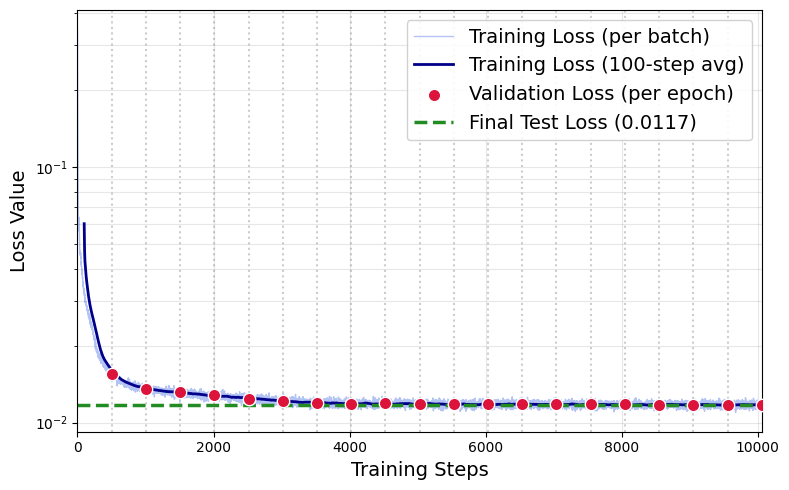

In [ ]:
# 可视化代码
plt.figure(figsize=(8, 5))

# 解包训练loss数据
train_steps, train_losses = zip(*train_batch_losses)
# 解包验证loss数据
val_steps, val_losses = zip(*val_epoch_losses)

# 绘制训练loss曲线（半透明处理避免过于密集）
plt.plot(train_steps, train_losses, 
         color='royalblue', 
         alpha=0.4, 
         linewidth=1,
         label='Training Loss (per batch)')

# 添加训练loss的滑动平均（窗口大小为100步）
window_size = 100
train_smoothed = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
plt.plot(train_steps[window_size-1:], train_smoothed,
         color='darkblue',
         linewidth=2,
         label=f'Training Loss ({window_size}-step avg)')

# 绘制验证loss
plt.scatter(val_steps, val_losses,
            color='crimson',
            s=80,
            edgecolors='white',
            zorder=3,
            label='Validation Loss (per epoch)')

# 添加最终测试loss
plt.axhline(y=avg_test_loss,
            color='forestgreen',
            linestyle='--',
            linewidth=2.5,
            label=f'Final Test Loss ({avg_test_loss:.4f})')

# 添加特殊标注
# plt.text(0.05, 0.95,
#          f'Best Val Loss: {min(val_losses):.4f}\n'
#          f'Final Test Loss: {avg_test_loss:.4f}',
#          transform=plt.gca().transAxes,
#          verticalalignment='top',
#          bbox=dict(facecolor='white', alpha=0.9))

# 图表装饰
# plt.title('Training Process Monitoring', fontsize=14, pad=20)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.xlim(0,10060)
plt.yscale('log')  # 对数坐标轴更好显示变化
plt.grid(True, alpha=0.3, which='both')
plt.legend(loc='upper right', framealpha=0.9, fontsize = 14)

# 添加epoch分隔线
for step in val_positions[:-1]:  # 排除最后一个验证点
    plt.axvline(x=step, color='gray', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.savefig("img/LossIMG.png", dpi=300, format="png", bbox_inches="tight")  # 保存为 PNG
plt.show()

In [14]:
plt.figure(figsize=(10, 6))
plt.plot( train_losses, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (log scale)', fontsize=14)
plt.title('Training Loss Curve (semilog)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6, which='both')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>

sample

In [18]:
import scipy.io as sio
# model_path = "results/vae_model_scaled_v2.pth"
model_path = "results/CVAE_model_train_val_test.pth"
model = CVAE_v2()
model.load_state_dict(torch.load(model_path))

from src.utils import gengrate_sample
Y_Samples = [37.6308,-0.1257]
cond = np.asarray(Y_Samples).reshape(-1,2)
cond_scaled = np.zeros(cond.shape)
for i in range(2):
    cond_scaled[:, i] = y_scalers[i].transform(cond[:, i].reshape(-1, 1)).flatten()

X_Samples_scaled = gengrate_sample(model, cond=cond_scaled.reshape(2,),num_samples=1000,sample_std=5)


X_Samples = np.zeros(X_Samples_scaled.shape)
for i in range(4):
    X_Samples[:, i] = x_scalers[i].inverse_transform(X_Samples_scaled[:, i].reshape(-1, 1)).flatten()
# 保存为MATLAB的.mat文件
sio.savemat('results/samples_VAE0508_std5_validation_1000.mat', {
    'X_samples': X_Samples,
    'Y_samples': Y_Samples
})

X_Samples

array([[2.57486547e-03, 9.58417475e-01, 1.76960480e+00, 6.25748187e-04],
       [1.32204650e-03, 4.79961544e-01, 1.79500258e+00, 3.45686497e-03],
       [2.29200488e-03, 9.17943954e-01, 1.77952933e+00, 1.65522005e-03],
       ...,
       [2.05263705e-03, 8.90467763e-01, 1.79833198e+00, 3.96734243e-03],
       [2.76340987e-03, 1.11189902e+00, 1.77201796e+00, 1.40155526e-03],
       [2.78902589e-03, 1.15733957e+00, 1.82704604e+00, 4.10002191e-03]],
      shape=(1000, 4))

In [19]:
shared_path = "/mnt/d/读博生活/博2024-2025/2406庞加莱截面编队筛选方法/Matlab/J2-exp(0)/Poincare_2408/PythonSharedData"

sio.savemat(shared_path + '/samples_VAE0508_std5_validation_1000.mat', {
    'X_samples': X_Samples,
    'Y_samples': Y_Samples
})

In [ ]:

# import matlab.engine
# # 启动MATLAB引擎
# eng = matlab.engine.start_matlab()

# #从sample中提取4个参数
# current_k = samples[:, 0].tolist()      # 转为Python list（MATLAB兼容）
# current_alpha = samples[:, 1].tolist()
# current_Hz = samples[:, 2].tolist()    
# current_DeltE = samples[:, 3].tolist()

# Td_learning = []
# OMGd_learning = []

# for hz, k, alpha, de in zip(current_Hz, current_k, current_alpha, current_DeltE):
#     # 将参数转换为MATLAB double类型
#     hz_matlab = matlab.double([hz])
#     k_matlab = matlab.double([k])
#     alpha_matlab = matlab.double([alpha])
#     de_matlab = matlab.double([de])
    
#     # 调用函数，获取输出
#     Td, OMGd = eng.TimeNAngleGenerate_Peri(hz_matlab, k_matlab, alpha_matlab, de_matlab, nargout=2)
    
#     # 转换为Python列表并保存
#     Td_learning.append(np.array(Td._data).flatten())  # 转为NumPy数组
#     OMGd_learning.append(np.array(OMGd._data).flatten())

# eng.quit()

# Td_array = np.vstack(Td_list)    # 假设每个输出是1D数组
# OMGd_array = np.vstack(OMGd_list)


In [ ]:
plt.figure()
plt.hist(samples[:, 0], bins=20, alpha=0.7, label='x1')
plt.hist(samples[:, 1], bins=20, alpha=0.7, label='x2')
plt.legend()

In [ ]:
device = "cuda"

model_nn = simple_mle().to(device)
optimizer_nn = optim.Adam(model.parameters(), lr=1e-3)
loss_fn_nn = nn.MSELoss()

In [ ]:
n_epochs = 10
for epoch in range(n_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        x_pred = model_nn(x_batch)
        loss = loss_fn_nn(x_pred, y_batch)
        # x_recon, mu, logvar = model(x_batch, y_batch)
        # loss = loss_fn(x_recon, x_batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")


torch.save(model.state_dict(), "results/mle_model.pth")

In [ ]:
model_path = "results/mle_model.pth"
model = simple_mle()
model.load_state_dict(torch.load(model_path))

from src.utils import gengrate_sample
from src.utils import gengrate_sample_mle
# samples_scaled = gengrate_sample_mle(model, cond=[y_scalers[0].transform(57.67),y_scalers[0].transform(-0.39)],num_samples=10,sample_std=10)
cond = np.asarray([57.67,-0.39]).reshape(-1,2)
cond_scaled = np.zeros(cond.shape)
for i in range(2):
    cond_scaled[:, i] = y_scalers[i].transform(cond[:, i].reshape(-1, 1)).flatten()
# samples_scaled = gengrate_sample(model, cond = cond_scaled.reshape(2,),num_samples=10,sample_std=1)
samples_scaled = gengrate_sample_mle(model, cond_scaled.reshape(2,),num_sample=10)